## Import libraries

In [14]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from lenet5 import LeNet
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


## Set Parameters

In [22]:
# Check if cuda is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model Training Parameters
LEARNING_RATE = 2e-3  # LR
BATCH_SIZE = 32
ROUNDS = 10  # R
LOCAL_EPOCHS = 10  # E
NUM_CLIENTS = 20  # K: number of total clients
C = 0.3  # percentage of clients selected at each round
# m = C * K : number of  clients selected at each round
NUM_SELECTED = max(int(C * NUM_CLIENTS), 1)

# Save plots in the folder ./plots or show them
SAVE_PLOTS = True


## Training and Validation functions

In [16]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    for X, y_target in train_loader:

        # set gradient to zero
        optimizer.zero_grad()

        # If there is a GPU, pass the data to GPU
        X = X.to(device)
        y_target = y_target.to(device)

        # Prediction

        # Call model forward()
        y_predict, _ = model(X)

        # Get loss
        loss = criterion(y_predict, y_target)
        running_loss += loss.item() * X.size(0)

        # Adjusting weights
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def test(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for X, y_target in valid_loader:

        # If there is a GPU, pass the data to the GPU
        X = X.to(device)
        y_target = y_target.to(device)

        # Prediction and loss

        # Call model forward()
        y_predict, _ = model(X)

        # Get loss
        loss = criterion(y_predict, y_target)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
    return model, epoch_loss


def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n


def client_update(model, optimizer, train_loader, device, criterion, epochs):
    """
    This function updates/trains client model on client data
    """
    for e in range(epochs):
        model, optimizer, train_loss = train(train_loader, model,
                                             criterion, optimizer, device)
    return train_loss


def server_aggregate(global_model, client_models):
    """
    This function has aggregation method 'mean'
    """
    # This will take simple mean of the weights of models
    global_dict = global_model.state_dict()

    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict(
        )[k].float() for i in range(len(client_models))], 0).mean(0)

    global_model.load_state_dict(global_dict)

    for model in client_models:
        model.load_state_dict(global_model.state_dict())


In [17]:

def training_loop(centralizedModel, federatedModels, criterion, optimizers, train_loader, test_loader,
                  rounds, epochs, num_clients, num_selected, device, print_every=1):

    global_train_losses = []  # Average train losses between clients
    global_valid_losses = []  # Average validation losses between clients

    global_train_accuracies = []  # Average train accuracies between clients
    global_valid_accuracies = []  # Average validation accuracies between clients

    # Train model
    for round in range(rounds):

        # Select random clients
        # Select in the total number of clients, a random array of clients of size num_selected at each round
        client_idx = np.random.permutation(num_clients)[:num_selected]

        local_train_losses = []  # Local train losses of the clients in this round
        local_valid_losses = []  # Local validation losses of the clients in this round

        local_train_accuracies = []  # Local train accuracies of the clients in this round
        # Local validation accuracies of the clients in this round
        local_valid_accuracies = []

        for i in range(num_selected):
            # Train federated model locally in client i for num_epochs epochs
            local_train_loss = client_update(
                federatedModels[i], optimizers[i], train_loader[client_idx[i]], device, criterion, epochs)
            local_train_acc = get_accuracy(
                federatedModels[i], train_loader[client_idx[i]], device)

            local_train_losses.append(local_train_loss)
            local_train_accuracies.append(local_train_acc)

            local_valid_loss = test(
                test_loader, federatedModels[i], criterion, device)[1]
            local_valid_acc = get_accuracy(
                federatedModels[i], test_loader, device)

            local_valid_losses.append(local_valid_loss)
            local_valid_accuracies.append(local_valid_acc)

        server_aggregate(centralizedModel, federatedModels)

        # Calculate avg training loss over all selected users at each round
        local_train_loss_avg = sum(
            local_train_losses) / len(local_train_losses)
        global_train_losses.append(local_train_loss_avg)

        # Calculate avg training accuracy over all selected users at each round
        local_train_acc_avg = sum(
            local_train_accuracies) / len(local_train_accuracies)
        global_train_accuracies.append(local_train_acc_avg)

        # Calculate avg valid loss over all selected users at each round
        local_valid_loss_avg = sum(
            local_valid_losses) / len(local_valid_losses)
        global_valid_losses.append(local_valid_loss_avg)

        # Calculate avg valid accuracy over all selected users at each round
        local_valid_acc_avg = sum(
            local_valid_accuracies) / len(local_valid_accuracies)
        global_valid_accuracies.append(local_valid_acc_avg)

        print(f'Round: {round}\t'
              f'Train loss: {local_train_loss_avg:.4f}\t'
              f'Valid loss: {local_valid_loss_avg:.4f}\t'
              f'Train accuracy: {100 * local_train_acc_avg:.2f}\t'
              f'Valid accuracy: {100 * local_valid_acc_avg:.2f}')
    return centralizedModel, federatedModels, optimizers, (global_train_losses, global_valid_losses), (global_train_accuracies, global_valid_accuracies)


## Loaders and Transformations

In [18]:
# Image augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalizing the test images
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Loading CIFAR10 using torchvision.datasets
traindata = datasets.CIFAR10('./data', train=True, download=False,
                             transform=transform_train)


# Dividing the training data into num_clients, with each client having equal number of images
traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0]
                                                                / NUM_CLIENTS) for _ in range(NUM_CLIENTS)])

# Creating a pytorch loader for a Deep Learning model
train_loader = [torch.utils.data.DataLoader(
    x, batch_size=BATCH_SIZE, shuffle=True) for x in traindata_split]


# Loading the test iamges and thus converting them into a test_loader
test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./data', train=False,
                                                           transform=transforms.Compose([transforms.ToTensor(),
                                                                                         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
                                                           ), batch_size=BATCH_SIZE, shuffle=True)


## Model Selection

In [19]:
model = LeNet().to(DEVICE)
centralizedModel = model

# list of models, model per device SELECTED ( same model for each device in our case)
federatedModels = [model for _ in range(NUM_SELECTED)]

for models in federatedModels:
    # we initialize every model with the central
    models.load_state_dict(centralizedModel.state_dict())


optimizers = [torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
              for model in federatedModels]
criterion = nn.CrossEntropyLoss()


## Train

In [20]:
centralizedModel, federatedModels, optimizers, (train_losses, valid_losses), (train_accuracies, valid_accuracies) = training_loop(
    centralizedModel, federatedModels, criterion, optimizers, train_loader, test_loader, ROUNDS, LOCAL_EPOCHS, NUM_CLIENTS, NUM_SELECTED, DEVICE)


Round: 0	Train loss: 1.9328	Valid loss: 1.9281	Train accuracy: 28.34	Valid accuracy: 30.27
Round: 1	Train loss: 1.5703	Valid loss: 1.5537	Train accuracy: 40.73	Valid accuracy: 42.83
Round: 2	Train loss: 1.4096	Valid loss: 1.4391	Train accuracy: 46.11	Valid accuracy: 48.20
Round: 3	Train loss: 1.2745	Valid loss: 1.3340	Train accuracy: 50.86	Valid accuracy: 52.02
Round: 4	Train loss: 1.1662	Valid loss: 1.1746	Train accuracy: 57.43	Valid accuracy: 58.26
Round: 5	Train loss: 1.0831	Valid loss: 1.2579	Train accuracy: 55.79	Valid accuracy: 56.49
Round: 6	Train loss: 1.0235	Valid loss: 1.0843	Train accuracy: 61.41	Valid accuracy: 61.90
Round: 7	Train loss: 0.9734	Valid loss: 1.0507	Train accuracy: 63.93	Valid accuracy: 62.99
Round: 8	Train loss: 0.9415	Valid loss: 1.0120	Train accuracy: 63.51	Valid accuracy: 64.30
Round: 9	Train loss: 0.8689	Valid loss: 0.9596	Train accuracy: 66.32	Valid accuracy: 66.12


## Plot Accuracy and Loss

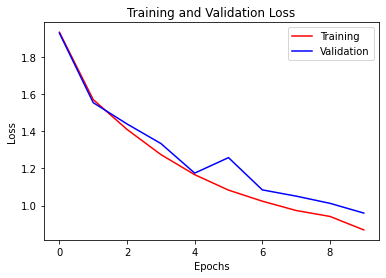

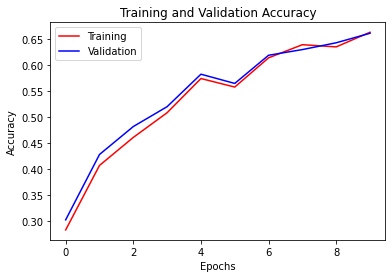

In [23]:
if SAVE_PLOTS:
    matplotlib.use("Agg")

# Plot Loss
plt.figure()
plt.title("Training and Validation Loss")
plt.plot(range(len(train_losses)), train_losses, color="r", label="Training")
plt.plot(range(len(valid_losses)), valid_losses, color="b", label="Validation")
plt.legend(loc="best")
plt.ylabel("Loss")
plt.xlabel("Epochs")
if SAVE_PLOTS:
    plt.savefig("plots/federated_LR[{}]_R[{}]_K[{}]_C[{}]_E[{}]_loss.png".format(
        LEARNING_RATE, ROUNDS, NUM_CLIENTS, C, LOCAL_EPOCHS))
else:
    plt.show()

# Plot Accuracy
plt.figure()
plt.title("Training and Validation Accuracy")
plt.plot(range(len(train_accuracies)),
         train_accuracies, color="r", label="Training")
plt.plot(range(len(valid_accuracies)), valid_accuracies,
         color="b", label="Validation")
plt.legend(loc="best")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
if SAVE_PLOTS:
    plt.savefig("plots/federated_LR[{}]_R[{}]_K[{}]_C[{}]_E[{}]_accuracy.png".format(
        LEARNING_RATE, ROUNDS, NUM_CLIENTS, C, LOCAL_EPOCHS))
else:
    plt.show()
